[*********************100%***********************]  1 of 1 completed


/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


                    count_open  count_high  count_low  count_close  count_sum  \
dollar_price_point                                                              
20.0                      27.0        15.0       29.0         27.0       98.0   
21.0                      24.0        30.0       16.0         23.0       93.0   
84.0                      17.0        14.0       11.0         15.0       57.0   
18.0                      17.0         6.0       18.0         16.0       57.0   
19.0                      11.0        20.0       13.0         13.0       57.0   
...                        ...         ...        ...          ...        ...   
159.0                      0.0         1.0        0.0          0.0        1.0   
162.0                      0.0         1.0        0.0          0.0        1.0   
164.0                      1.0         0.0        0.0          0.0        1.0   
143.0                      0.0         1.0        0.0          0.0        1.0   
175.0                      0

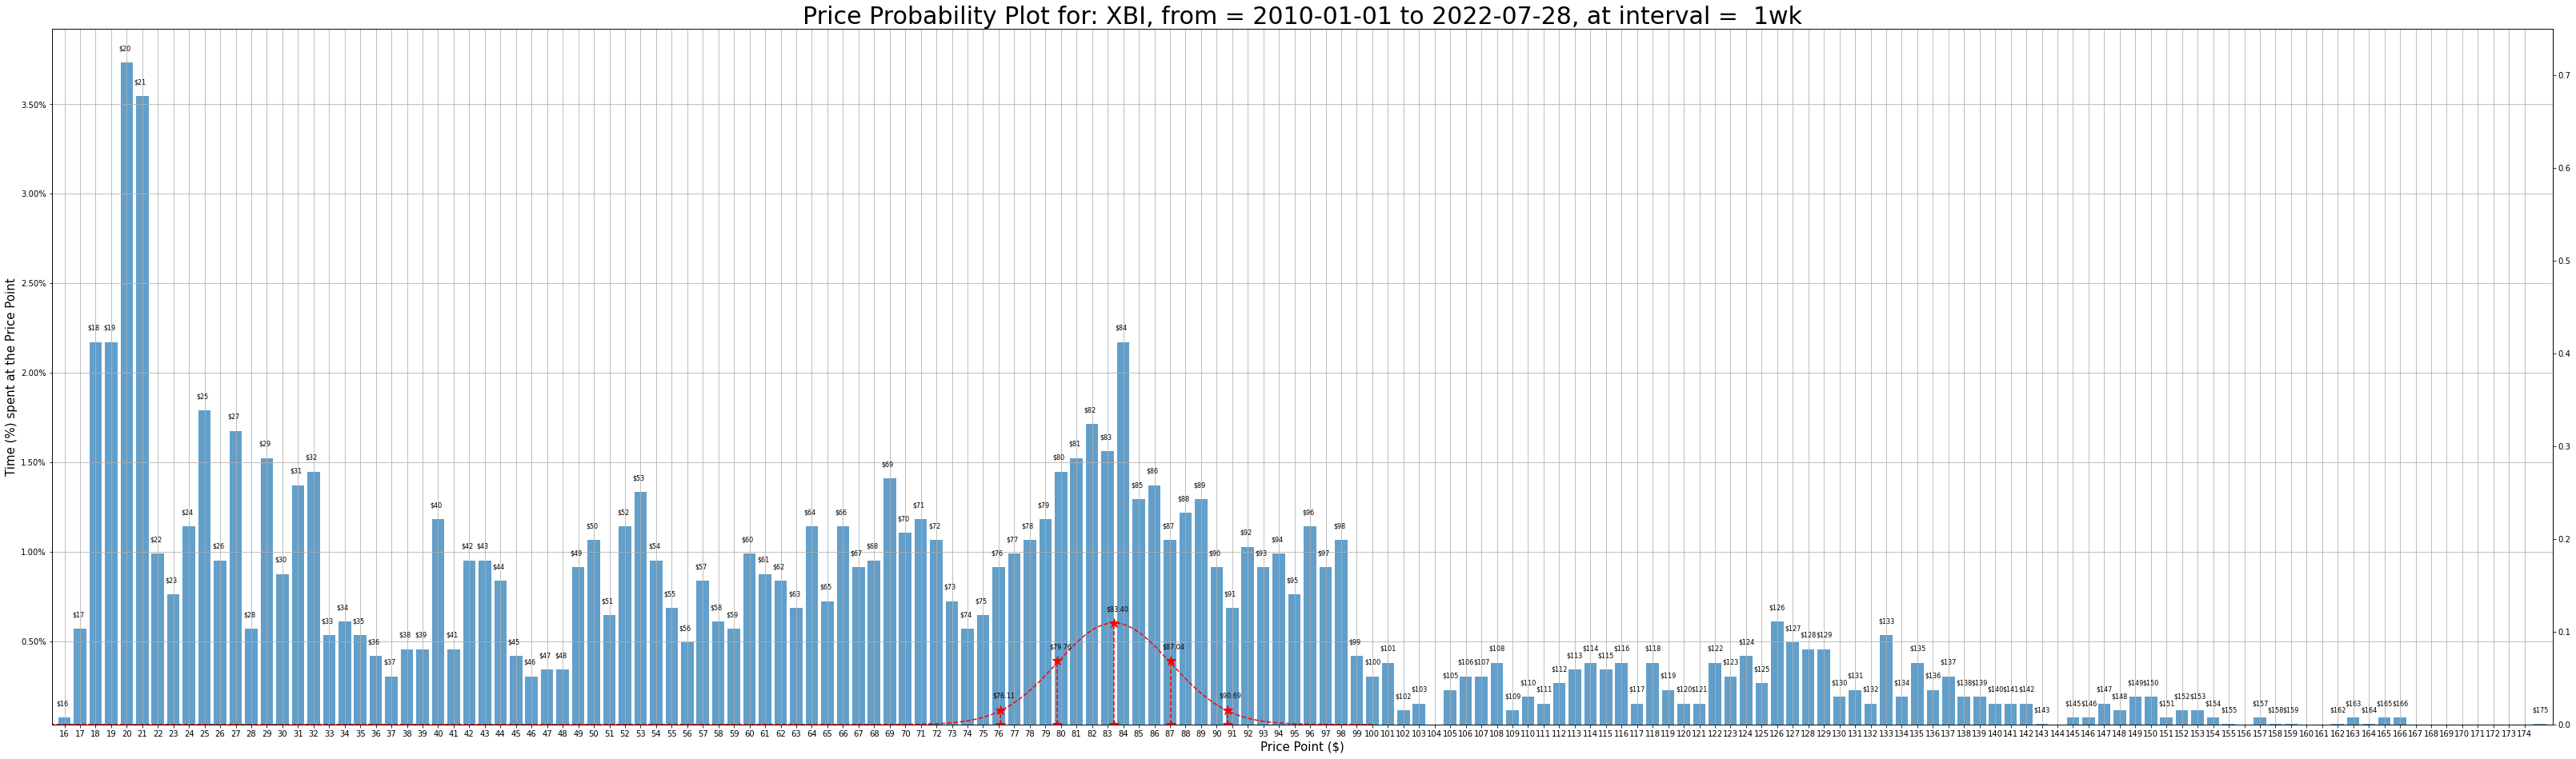

In [13]:
# Import Modules
import math
import numpy as np
import pandas as pd
import yfinance as yf
from scipy import stats
from datetime import date
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Input Variables
ticker = "XBI"
start_date = "2010-01-01"
end_date = date.today()
time_interval = "1wk"
rounding_base = 1

# Download Historical Data from Yahoo Finance
def get_stock_data(ticker, start_date, end_date, time_interval):
    df = yf.download(ticker, start_date, end_date, interval = time_interval).dropna()
    return df


# Extract the Last Closing Price
def get_last_price(df):
    last_price = df.Close[len(df.Close) - 1]
    return last_price


# Calcualate Standard Deviation of the Log Return
def get_st_dev(df):
    df["log_r"] = np.log(df.Close) - np.log(df.Close.shift(1))
    st_dev_pct = np.std(df.log_r)
    return st_dev_pct


# Round Historical Data
def round_data(df, rounding_base):
    df = rounding_base * round(df / rounding_base)
    return df


# Group Historical Data by counting the sum of Opens, High, Lows and Closes (OHLC) for each Price Point
def group_data(df):
    df["Date"] = df.index

    # Individually group OHLC columns
    df_group_open = pd.DataFrame(
        df.groupby("Open").count().sort_values(by="Date", ascending=False).Date
    )
    df_group_high = pd.DataFrame(
        df.groupby("High").count().sort_values(by="Date", ascending=False).Date
    )
    df_group_low = pd.DataFrame(
        df.groupby("Low").count().sort_values(by="Date", ascending=False).Date
    )
    df_group_close = pd.DataFrame(
        df.groupby("Close").count().sort_values(by="Date", ascending=False).Date
    )

    # Join OHLC columns
    df_joined = df_group_open.join(df_group_high, how="outer", rsuffix="o", sort=True)
    df_joined = df_joined.join(df_group_low, how="outer", rsuffix="h", sort=True)
    df_joined = df_joined.join(df_group_close, how="outer", rsuffix="l", sort=True).fillna(0)
    # Rename columns and index
    df_joined.columns = ["count_open", "count_high", "count_low", "count_close"]
    df_joined.index.name = "dollar_price_point"
    # Add sum column
    df_joined["count_sum"] = df_joined.sum(axis=1)
    # Add percentage sum column
    df_joined["count_sum_pct"] = df_joined.count_sum / np.sum(df_joined.count_sum)
    # Sort by percentage sum
    df_joined = df_joined.sort_values(by="count_sum_pct", ascending=False)
    return df_joined


# Plot the Grouped Data
def plot_data(df, ticker, start_date, end_date, rounding_base):
    fig, ax = plt.subplots()
    # Set X and Y
    X = df.index
    Y = df.count_sum_pct
    # Create Bar Plot
    ax.bar(X, Y, alpha=0.7)
    # Add Grid
    ax.grid()
    # Resize Plot
    fig.set_size_inches(56, 16)
    # Add X-ticks
    ax.xaxis.set_ticks(np.arange(np.min(X), np.max(X), rounding_base))
    # Change Y-axis format to percent
    ax.yaxis.set_major_formatter(
        mtick.PercentFormatter(xmax=1, decimals=None, symbol="%", is_latex=False)
    )
    # Set X-label
    ax.set_xlabel("Price Point ($)", size=15)
    # Set Y-label
    ax.set_ylabel('Time (%) spent at the Price Point', size=15)
    # Set Title
    ax.set_title(
        "Price Probability Plot for: "
        + ticker
        + ", from = "
        + str(start_date)
        + " to "
        + str(end_date)
        + ", at interval =  "
        + time_interval,
        size=30,
    )
    # Add data labels
    for x, y in zip(X, Y):
        label = "${:.0f}".format(x)
        plt.annotate(
            label,  
            (x, y),  
            textcoords="offset points",  
            xytext=(-10, 15),  
            fontsize=8,
            ha="left",
        )  
    # Set axes limits
    ax.set_xlim(np.min(X) * 0.95, np.max(X) + np.min(X) * 0.05)
    ax.set_ylim(np.min(Y) * 0.95, np.max(Y) * 1.05)
    return (fig, ax)


def plot_normal(fig, ax, last_price, st_dev_pct):
    # Add second Y-axis
    ax1 = ax.twinx()
    # Plot the bell-curve
    mu = last_price
    st_dev_dollar = st_dev_pct * last_price
    snd = stats.norm(mu, st_dev_dollar)
    x = np.linspace(0, 100, 1000)
    y = snd.pdf(x)
    ax1.plot(x, y, "--r")
    ax1.set_ylim(0, 0.75)

    # Plot Stadnard Deviation Points
    sigmas = [
        mu,
        mu + st_dev_dollar,
        mu + st_dev_dollar * 2,
        mu - st_dev_dollar,
        mu - st_dev_dollar * 2,
    ]

    heights = [
        np.max(y),
        np.max(y) / 1.6,
        np.max(y) / 7,
        np.max(y) / 1.6,
        np.max(y) / 7,
    ]

    for x, y in zip(sigmas, heights):
        ax1.plot([x, x], [0, y], "--*r", markersize=12)

        plt.annotate(
            "${:.2f}".format(x),
            (x, y),
            textcoords="offset points",
            xytext=(-10, 15),
            fontsize=8,
            ha="left",
        )

    return ax.plot

# Putting it together
def execute():
    df = get_stock_data(ticker, start_date, end_date, time_interval)
    last_price = get_last_price(df)
    st_dev_pct = get_st_dev(df)
    df = round_data(df, rounding_base)
    df = group_data(df)
    df.to_csv(
        "price_frequency_"
        + ticker
        + "_"
        + str(start_date)
        + "_"
        + str(end_date)
        + ".csv"
    )
    fig, ax = plot_data(df, ticker, start_date, end_date, rounding_base)
    plot_normal(fig, ax, last_price, st_dev_pct)
    plt.savefig(
        "price_probability_plot_"
        + ticker
        + "_"
        + str(start_date)
        + "_"
        + str(end_date)
        + ".png"
    )
    
    print(df)


if __name__ == "__main__":
    execute()